In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_host_device_count(4)
print ('# jax device count:', jax.local_device_count())

# jax device count: 4


In [2]:
npl = 2
datadir = "./kep9/"
names = ['ttv-b.txt', 'ttv-c.txt']

In [3]:
tcobs, errorobs, p_init = [], [], []
for n in names:
    fname = datadir + n
    _d = pd.read_csv(fname, delim_whitespace=True)
    tnum, tc, tcerr = np.array(_d[['N', 'T0', 'sigma_T0']]).T
    tcerr /= 1440.
    tcobs.append(tc)
    errorobs.append(tcerr)
    p, t0 = np.polyfit(tnum, tc, deg=1)
    p_init.append(p)
p_init = np.array(p_init)

In [4]:
import itertools
tclist = list(itertools.chain.from_iterable(tcobs))
print (p_init[0], p_init[0]/40.)
print (np.min(tclist), np.max(tclist))

19.246113950740423 0.48115284876851055
136.30647 1587.53394


In [5]:
dt = 0.4 / 2.
t_start, t_end = 135, 1590.
jttv = jaxttv(t_start, t_end, dt)

# sympletic integrator is used.


In [6]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           135.00
# first transit time in data:      136.31
# last transit time in data:       1587.53
# integration ends at:             1590.00
# integration time step:           0.2000 (1/96 of innermost period)


initial objective function: 63542476.21 (107 data)

running LM optimization...
objective function: 144.24 (107 data)
# elapsed time (least square): 18.0 sec


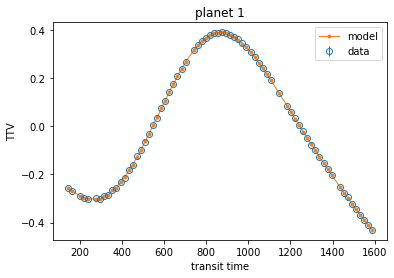

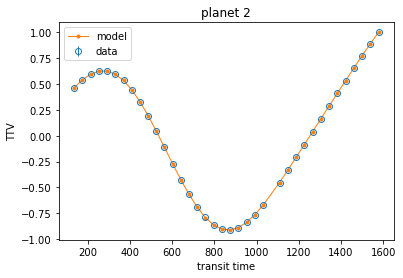

In [7]:
params_best = jttv.optim(amoeba=False, mmax=1e-3, emax=0.3)

In [8]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

       pmass     period     ecosw     esinw  cosi  lnode         tic  \
0  42.478917  19.228893  0.063156 -0.003493   0.0    0.0  144.249596   
1  29.252176  39.037224 -0.066577  0.013400  -0.0   -0.0  136.307117   

        ecc     omega    lnmass      mass      cosw      sinw  
0  0.063253 -0.055244 -8.966728  0.000128  0.998474 -0.055216  
1  0.067912  2.942971 -9.339782  0.000088 -0.980340  0.197318  


In [9]:
tc, de = jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))
print ("energy error:", de)

energy error: 3.663613634685703e-09


### residuals (cf. Figure 6/7 left in Borasto+2019 arXiv:1901.05471)

planet 1 res std: 8.88e-04	 res/raw err std: 1.21	 res/estimated err std: 1.21
planet 2 res std: 8.76e-04	 res/raw err std: 1.07	 res/estimated err std: 1.07


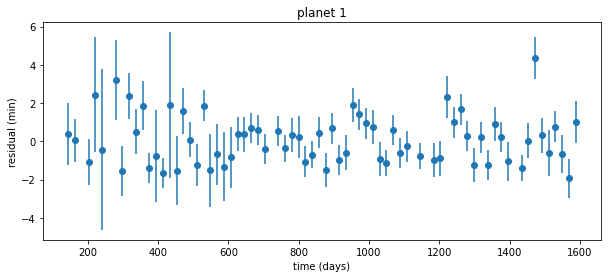

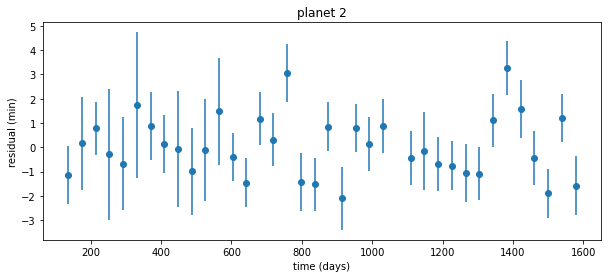

In [10]:
meanjit = 0
for j in range(npl):
    plt.figure(figsize=(10,4))
    _idx = jttv.pidx==j+1
    res = jttv.tcobs_flatten[_idx]-tc[_idx]
    err0 = jttv.errorobs_flatten[_idx]
    err = np.sqrt(err0**2 + meanjit**2)
    print ("planet", j+1, "res std: %.2e\t"%np.std(res), "res/raw err std: %.2f\t"%np.std(res/err0), 
           "res/estimated err std: %.2f"%np.std(res/err))
    #plt.errorbar(jttv.tcobs_flatten[_idx], res/jttv.errorobs_flatten[_idx], fmt='o')
    plt.errorbar(jttv.tcobs_flatten[_idx], res*1440, yerr=jttv.errorobs_flatten[_idx]*1440, fmt='o')
    plt.title("planet %d"%(j+1))
    plt.xlabel("time (days)")
    plt.ylabel('residual (min)')

### tc depends on integrator?

In [11]:
jttv2 = jaxttv(t_start, t_end, dt/10., symplectic=False)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# hermite integrator is used.
# integration starts at:           135.00
# first transit time in data:      136.31
# last transit time in data:       1587.53
# integration ends at:             1590.00
# integration time step:           0.0200 (1/962 of innermost period)


In [13]:
#tc2, de2 = jttv2.get_ttvs_hermite4(*params_to_elements(params_best, jttv.nplanet))
tc2, de2 = jttv2.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

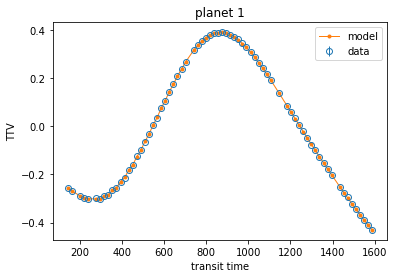

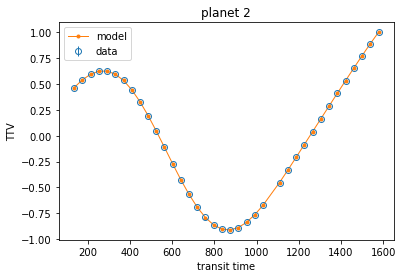

In [14]:
jttv.quicklook(tc2)

In [15]:
print ("max difference (sec):", np.max(np.abs(tc-tc2))*86400)

max difference (sec): 1.569714630022645


In [16]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

7.72 ms ± 40.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(p_init)
ones = jnp.ones_like(p_guess)

In [18]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=False):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    if tcjitter:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-8, high=-2))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [19]:
#pdic_init['lntcjitter'] = -4.8
init_strategy = init_to_value(values=pdic_init)
pdic_init

{'period': DeviceArray([19.22889348, 39.03722378], dtype=float64),
 'cosi': DeviceArray([ 0., -0.], dtype=float64),
 'lnode': DeviceArray([ 0., -0.], dtype=float64),
 'tic': DeviceArray([144.24959558, 136.30711677], dtype=float64),
 'ecc': DeviceArray([0.06325256, 0.06791205], dtype=float64),
 'lnmass': DeviceArray([-8.96672796, -9.33978187], dtype=float64),
 'mass': DeviceArray([1.27584974e-04, 8.78585983e-05], dtype=float64),
 'cosw': DeviceArray([ 0.99847444, -0.98033954], dtype=float64),
 'sinw': DeviceArray([-0.05521583,  0.19731796], dtype=float64)}

In [20]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)

In [21]:
nw, ns = 100, 100 # 1h20min
nw, ns = 500, 2000 # dt=0.2, 33h (not long enough)

In [22]:
ndev = jax.local_device_count()
if ndev > 1:
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=ndev, progress_bar=False)
else:
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [23]:
outdir = "kep9/linmass_dt%.1f_nw%d_ns%d_"%(dt, nw, ns)

In [25]:
outdir += "c4_"

In [ ]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=True)

In [33]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]      1.11      0.05      1.09      1.05      1.19      2.60      3.34
   cosw[1]     -0.87      0.04     -0.86     -0.94     -0.81      3.92      1.30
    ecc[0]      0.06      0.00      0.06      0.05      0.06      2.42      3.76
    ecc[1]      0.08      0.00      0.08      0.07      0.08      3.95      1.29
   mass[0]      0.00      0.00      0.00      0.00      0.00      5.67      1.41
   mass[1]      0.00      0.00      0.00      0.00      0.00      5.69      1.41
 period[0]     19.23      0.00     19.23     19.23     19.23     12.62      1.19
 period[1]     39.04      0.00     39.04     39.04     39.04      8.66      1.25
   sinw[0]     -0.06      0.01     -0.06     -0.08     -0.05      3.27      1.92
   sinw[1]      0.17      0.01      0.17      0.16      0.19      4.01      1.29
    tic[0]    144.25      0.00    144.25    144.25    144.25     24.08      1.01
    tic[1]    136.31      0

In [34]:
base

'kep9/linmass_dt0.2_nw500_ns2000_'

In [26]:
#outdir = 'kep9/linm_n500x4_'

In [39]:
import dill
with open(outdir+"mcmc.pkl", "wb") as f:
    dill.dump(mcmc, f)

In [40]:
samples = mcmc.get_samples()

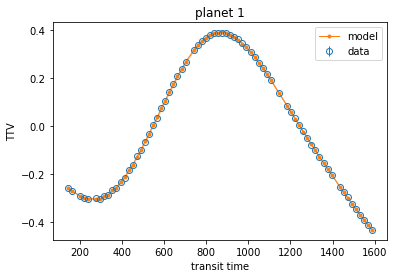

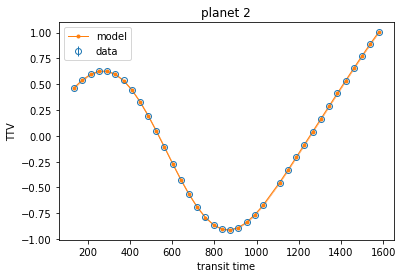

In [41]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel, save=outdir+"postm")

planet 1 res std: 8.91e-04	 res/raw err std: 1.21	 res/estimated err std: 1.21
planet 2 res std: 8.77e-04	 res/raw err std: 1.07	 res/estimated err std: 1.07


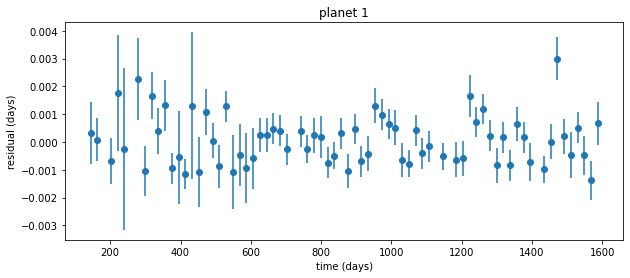

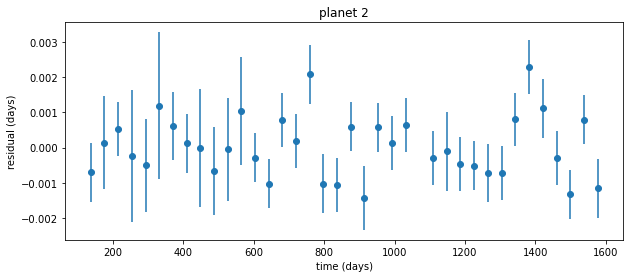

In [42]:
meanjit = 0
for j in range(npl):
    plt.figure(figsize=(10,4))
    _idx = jttv.pidx==j+1
    res = jttv.tcobs_flatten[_idx]-mmodel[_idx]
    err0 = jttv.errorobs_flatten[_idx]
    err = np.sqrt(err0**2 + meanjit**2)
    print ("planet", j+1, "res std: %.2e\t"%np.std(res), "res/raw err std: %.2f\t"%np.std(res/err0), 
           "res/estimated err std: %.2f"%np.std(res/err))
    #plt.errorbar(jttv.tcobs_flatten[_idx], res/jttv.errorobs_flatten[_idx], fmt='o')
    plt.errorbar(jttv.tcobs_flatten[_idx], res, yerr=jttv.errorobs_flatten[_idx], fmt='o')
    plt.title("planet %d"%(j+1))
    plt.xlabel("time (days)")
    plt.ylabel('residual (days)')

In [43]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

(array([ 24.,  41., 114., 315., 381., 374., 308., 240., 120.,  83.]),
 array([-8.44782332, -8.44532012, -8.44281693, -8.44031373, -8.43781053,
        -8.43530734, -8.43280414, -8.43030094, -8.42779775, -8.42529455,
        -8.42279136]),
 <BarContainer object of 10 artists>)

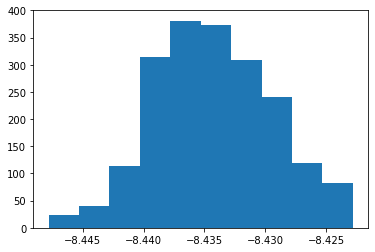

In [44]:
plt.hist(np.log10(np.abs(samples['ediff'])))

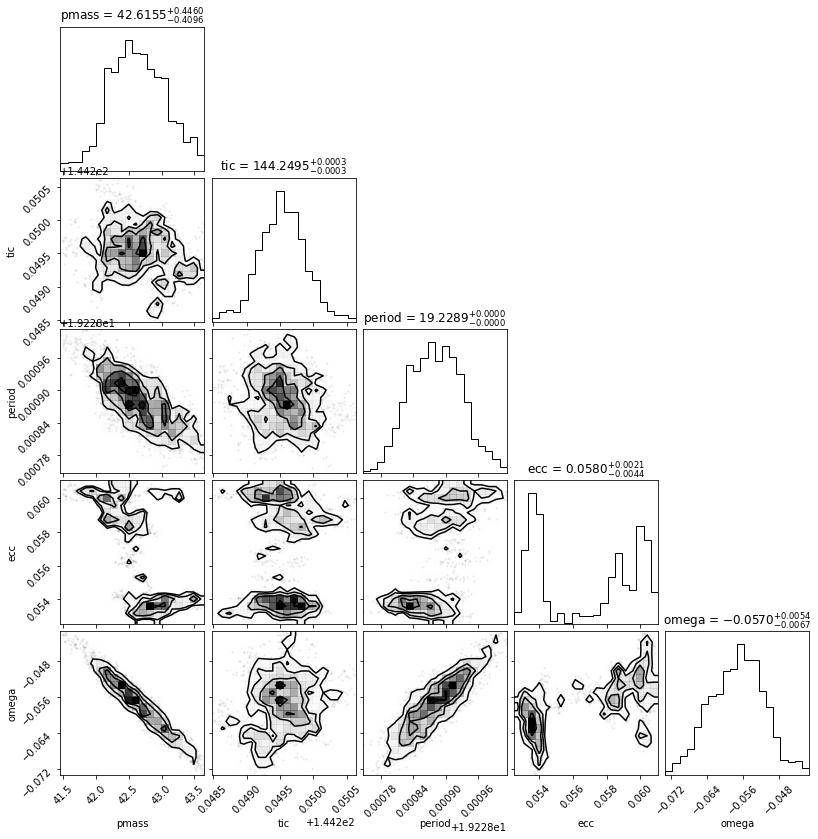

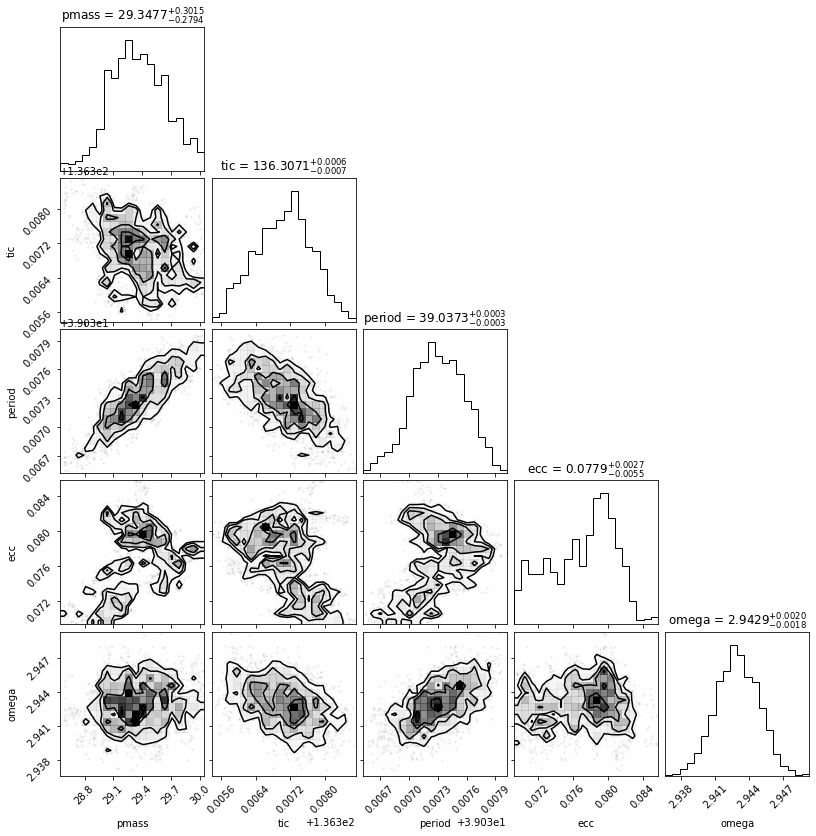

In [45]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    fig = corner.corner(hyper, labels=keys, show_titles=True, title_fmt=".4f")
    plt.savefig(outdir+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");

In [46]:
jttv2 = jaxttv(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# sympletic integrator is used.
# integration starts at:           135.00
# first transit time in data:      136.31
# last transit time in data:       1587.53
# integration ends at:             1590.00
# integration time step:           0.0200 (1/962 of innermost period)


In [47]:
k = 100

In [48]:
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))

(array([32.,  9., 12., 24.,  6.,  3.,  2.,  2.,  3., 14.]),
 array([-0.88224665, -0.63601253, -0.38977841, -0.1435443 ,  0.10268982,
         0.34892394,  0.59515805,  0.84139217,  1.08762629,  1.33386041,
         1.58009452]),
 <BarContainer object of 10 artists>)

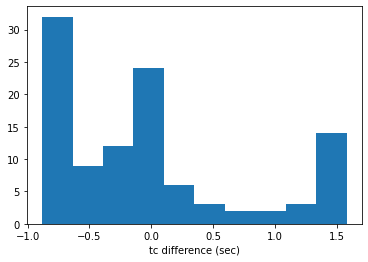

In [49]:
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.)